# Student Performance Regression Analysis

## Introduction
This notebook solves a regression problem to predict student performance using the "Student Performance (Multiple Linear Regression)" dataset from Kaggle. The goal is to predict a continuous target variable, likely grades, based on features such as study time, sleep time, or other factors. We will use multiple regression models, including Linear Regression, Lasso Regression, Random Forest Regression, Decision Tree, Support Vector Regression (SVR), Gradient Boosting Regression, and Bayesian Ridge Regression, and compare their performance using Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R2).

**Dataset**: [Student Performance Dataset](https://www.kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression)

**Objectives**:
- Explore the dataset to understand its structure and relationships.
- Preprocess the data for modeling.
- Train and evaluate multiple regression models.
- Visualize results to gain insights and compare model performance.

*Vasylenko Sofiia CS42*



## 1. Import Libraries
We import necessary libraries for data manipulation, modeling, and visualization.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp
import scipy.stats as stats

%matplotlib inline

## 2. Load and Explore the Dataset
We load the dataset and perform exploratory data analysis to understand its structure, check for missing values, and visualize relationships.

In [4]:
df = pd.read_csv('data/Student_Performance.csv')

print('First 5 rows of the dataset:')
print(df.head())

print('\nDataset Info:')
print(df.info())

print('\nSummary Statistics:')
print(df.describe())

print('\nMissing Values:')
print(df.isnull().sum())

First 5 rows of the dataset:
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                            Non-N

### Visualization: Distribution and Correlations
We create a pairplot to visualize relationships between features and a heatmap to show correlations.

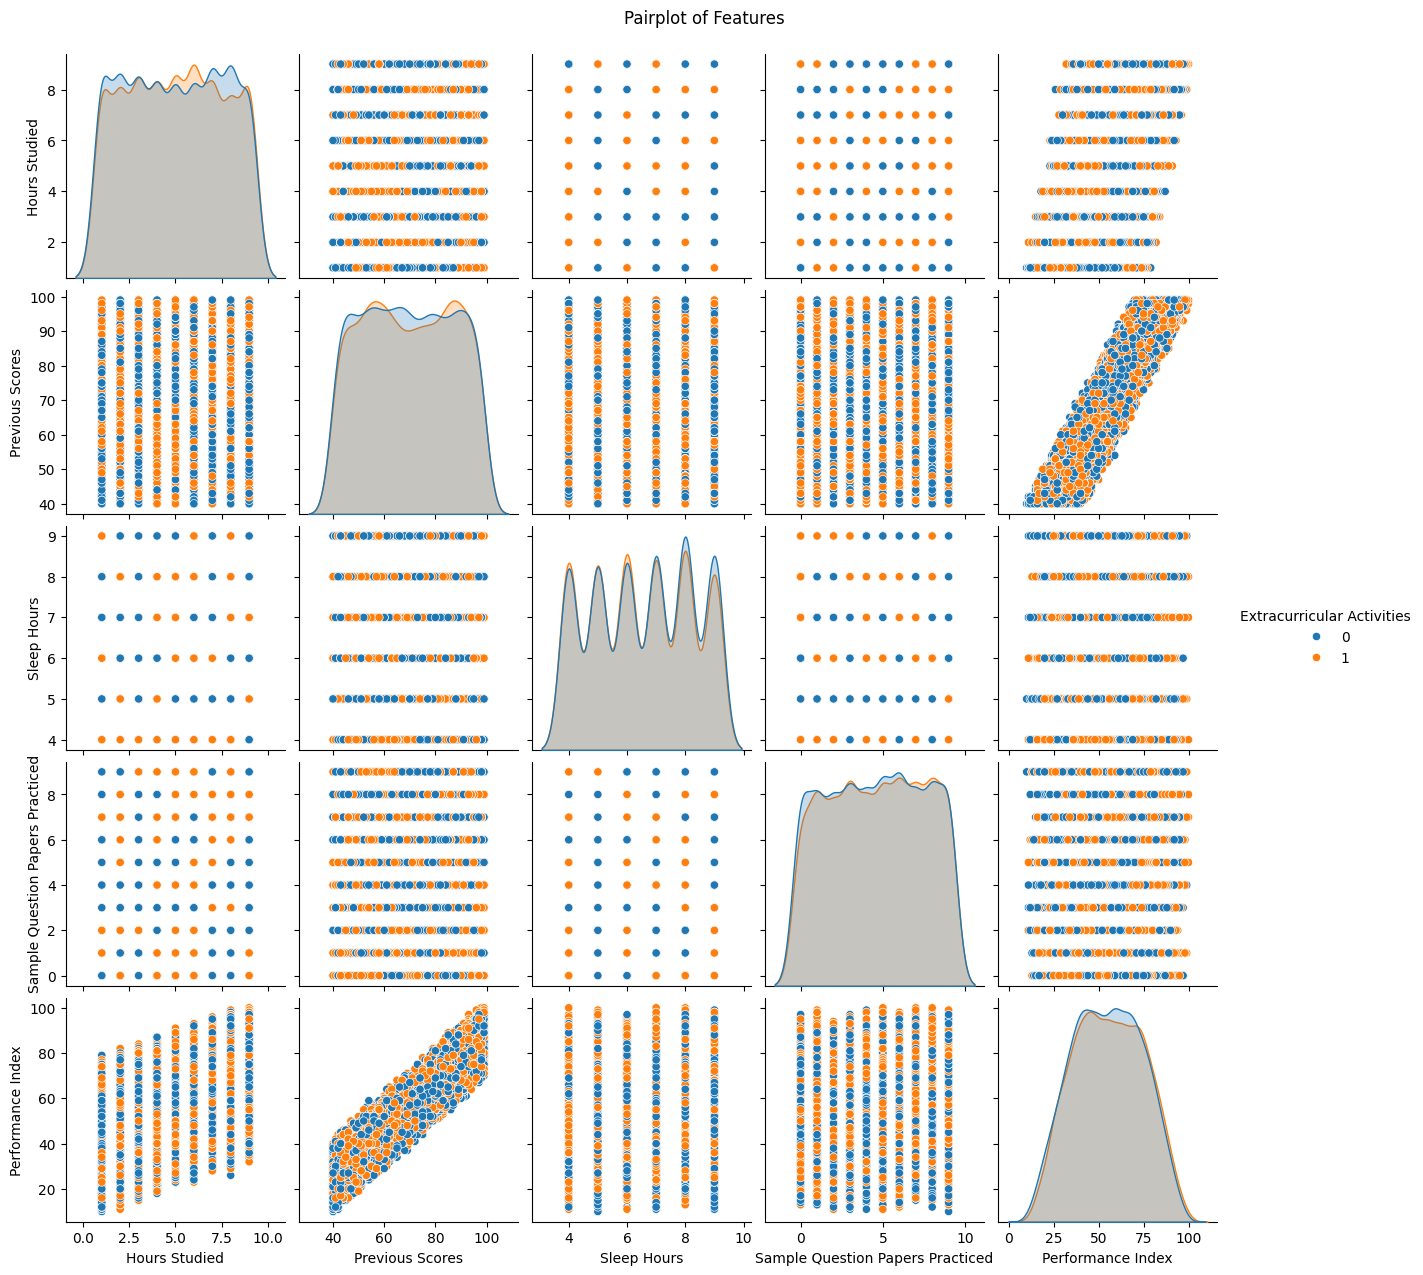

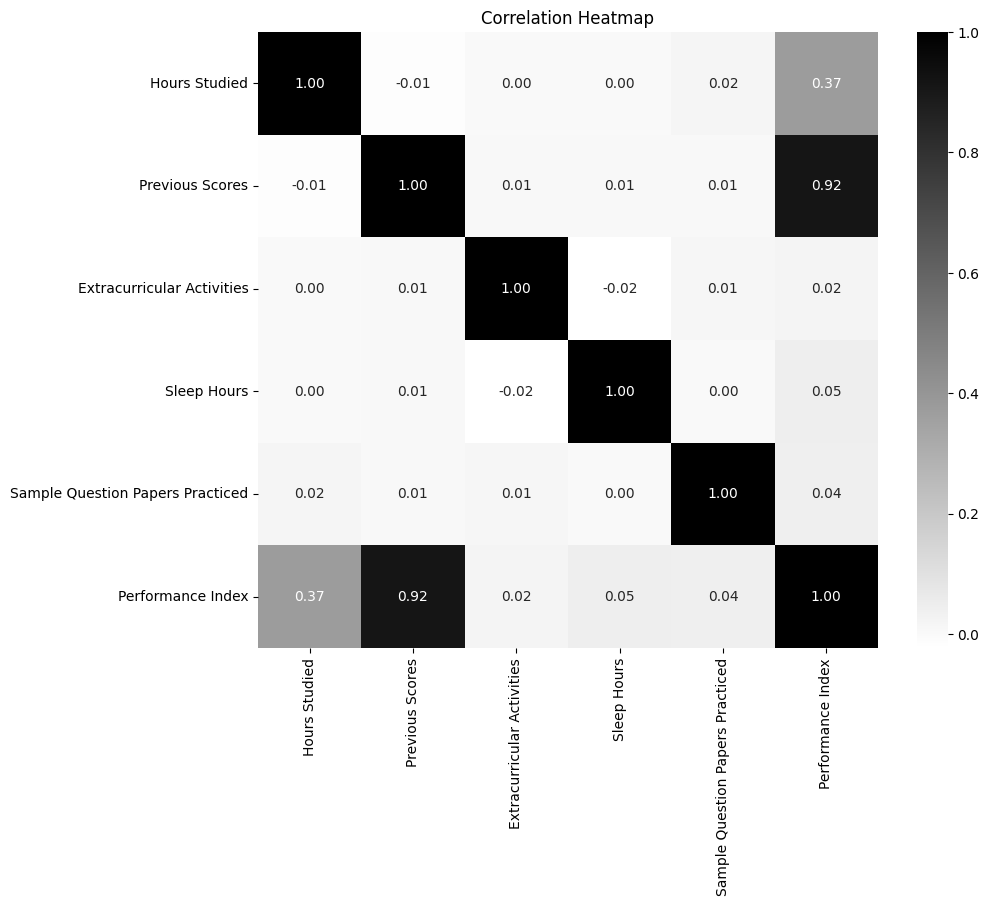

In [5]:
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

fig = px.scatter_3d(
    df,
    x='Hours Studied',
    y='Previous Scores',
    z='Performance Index',
    color='Extracurricular Activities',
    title='3D Scatter Plot: Hours Studied, Previous Scores, and Performance Index',
    opacity=0.7,
    size_max=10,
    color_continuous_scale=['blue', 'orange'],
    labels={'Extracurricular Activities Num': 'Extracurricular Activities (0=No, 1=Yes)'}
)

fig.update_layout(
    scene=dict(
        xaxis_title='Hours Studied',
        yaxis_title='Previous Scores',
        zaxis_title='Performance Index'
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.write_html("dataset_3d_visualisation.html")
fig.show()

sns.pairplot(df, hue='Extracurricular Activities')
plt.suptitle('Pairplot of Features', y=1.02)
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='binary', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Visualisation: Impact of Sample Questions Papers Practices

<ipython-input-6-1d80a0e49683>:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



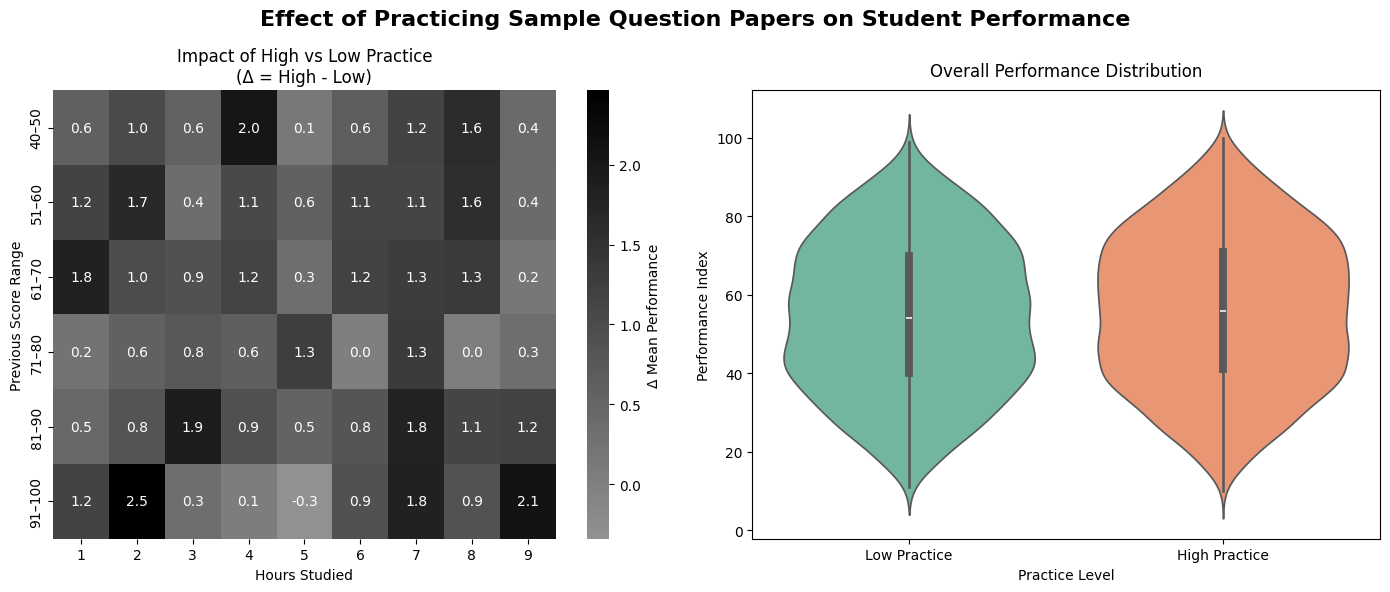

In [6]:
df['Practice Level'] = df['Sample Question Papers Practiced'].apply(lambda x: 'High Practice' if x > 4 else 'Low Practice')

df['Score Bin'] = pd.cut(df['Previous Scores'], bins=[39, 50, 60, 70, 80, 90, 100], labels=['40–50', '51–60', '61–70', '71–80', '81–90', '91–100'])

mean_perf = df.groupby(['Hours Studied', 'Score Bin', 'Practice Level'])['Performance Index'].mean().reset_index()

mean_high = mean_perf[mean_perf['Practice Level'] == 'High Practice'].pivot(index='Score Bin', columns='Hours Studied', values='Performance Index')
mean_low = mean_perf[mean_perf['Practice Level'] == 'Low Practice'].pivot(index='Score Bin', columns='Hours Studied', values='Performance Index')

diff = mean_high - mean_low

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(diff, cmap='binary', center=0, annot=True, fmt='.1f', cbar_kws={'label': 'Δ Mean Performance'})
plt.title('Impact of High vs Low Practice\n(Δ = High - Low)', fontsize=12)
plt.xlabel('Hours Studied')
plt.ylabel('Previous Score Range')

plt.subplot(1, 2, 2)
sns.violinplot(x='Practice Level', y='Performance Index', hue='Practice Level', data=df, palette='Set2', inner='box', legend=False)
plt.title('Overall Performance Distribution', fontsize=12, pad=10)
plt.xlabel('Practice Level', fontsize=10)
plt.ylabel('Performance Index', fontsize=10)

plt.suptitle('Effect of Practicing Sample Question Papers on Student Performance', fontsize=16, weight='bold')
plt.tight_layout()

df.drop(columns=['Practice Level', 'Score Bin'], inplace=True)


## 3. Data Preprocessing
We handle missing values, encode categorical variables, and scale features for models like SVR.

In [7]:
# Handle missing values (fill with mean for numerical columns)
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Split features and target
X = df.drop('Performance Index', axis=1)  # Replace grade with actual target column
y = df['Performance Index']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 4. Split the Data
We split the data into training and testing sets to evaluate model performance.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print(f'Training set size: {X_train.shape[0]} samples')
print(f'Testing set size: {X_test.shape[0]} samples')

Training set size: 8000 samples
Testing set size: 2000 samples


## 5. Train and Evaluate Models
We train regression models and evaluate their performance using MSE, MAE and R2.

### 5.1 Train models

In [9]:
models = {
    'Linear Regression': LinearRegression(fit_intercept=True),
    'Lasso Regression': Lasso(alpha=0.001),
    'Decision Tree': DecisionTreeRegressor(max_depth=12, min_samples_split=20, min_samples_leaf=20),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=12, min_samples_split=20, min_samples_leaf=20),
    'SVR': SVR(kernel='rbf'),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Bayesian Ridge': BayesianRidge()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results.append({'Model': name, 'Train MSE': train_mse, 'Train MAE': train_mae, 'Train R2': train_r2,
                    'Test MSE': test_mse, 'Test MAE' : test_mae, 'Test R2': test_r2})
    print(f'{name}:\n\tTrain MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}, Train R2: {train_r2:.4f}')
    print(f'\tTest MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

Linear Regression:
	Train MSE: 4.1697, Train MAE: 1.6193, Train R2: 0.9887
	Test MSE: 4.0826, Test MAE: 1.6111, Test R2: 0.9890
Lasso Regression:
	Train MSE: 4.1697, Train MAE: 1.6193, Train R2: 0.9887
	Test MSE: 4.0830, Test MAE: 1.6112, Test R2: 0.9890
Decision Tree:
	Train MSE: 5.0545, Train MAE: 1.7914, Train R2: 0.9863
	Test MSE: 5.8025, Test MAE: 1.9071, Test R2: 0.9843
Random Forest:
	Train MSE: 4.7684, Train MAE: 1.7394, Train R2: 0.9871
	Test MSE: 5.2257, Test MAE: 1.8215, Test R2: 0.9859
SVR:
	Train MSE: 5.2849, Train MAE: 1.7825, Train R2: 0.9857
	Test MSE: 5.4209, Test MAE: 1.8237, Test R2: 0.9854
Gradient Boosting:
	Train MSE: 4.1430, Train MAE: 1.6155, Train R2: 0.9888
	Test MSE: 4.3646, Test MAE: 1.6578, Test R2: 0.9882
Bayesian Ridge:
	Train MSE: 4.1697, Train MAE: 1.6193, Train R2: 0.9887
	Test MSE: 4.0827, Test MAE: 1.6111, Test R2: 0.9890


Desicion Tree and Random Forest, SV Regressions models show signs of overfitting

### 5.2 Feature Importance
We visualize feature importances.

In [ ]:
models_with_importance = {
    'Linear Regression': models['Linear Regression'],
    'Lasso Regression': models['Lasso Regression'],
    'Decision Tree': models['Decision Tree'],
    'Random Forest': models['Random Forest'],
    'Gradient Boosting': models['Gradient Boosting'],
    'Bayesian Ridge': models['Bayesian Ridge']
}

feature_names = X.columns

def get_feature_importance(model, name):
    if name in ['Decision Tree', 'Random Forest', 'Gradient Boosting']:
        return model.feature_importances_
    else:
        return np.abs(model.coef_)

importance_data = {}
for name, model in models_with_importance.items():
    importance = get_feature_importance(model, name)
    importance = importance / importance.max()
    importance_data[name] = importance

importance_df = pd.DataFrame(importance_data, index=feature_names).T

fig = go.Figure()

colors = {
    'Linear Regression': '#FF6F61',
    'Lasso Regression': '#6B728E',
    'Decision Tree': '#FFD60A',
    'Random Forest': '#06D6A0',
    'Gradient Boosting': '#118AB2',
    'Bayesian Ridge': '#073B4C'
}

for name, importance in importance_data.items():
    fig.add_trace(go.Scatterpolar(
        r=np.append(importance, importance[0]),
        theta=np.append(feature_names, feature_names[0]),
        #fill='toself',
        name=name,
        line=dict(color=colors[name]),
        fillcolor=colors[name],
        opacity=0.8,
        hovertemplate=f'<b>{name}</b><br>Feature: %{{theta}}<br>Importance: %{{r:.2f}}<extra></extra>'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1],
            tickvals=[0, 0.25, 0.5, 0.75, 1],
            ticktext=['0', '0.25', '0.5', '0.75', '1']
        ),
        angularaxis=dict(
            rotation=90,
            direction="clockwise"
        )
    ),
    title=dict(
        text="Feature Importance Radar",
        x=0.5,
        xanchor="center",
        font=dict(size=18)
    ),
    width=800,
    height=800,
    template="plotly_white",
    legend=dict(x=1.1, y=1.0, font=dict(size=12)),
    showlegend=True
)

fig.write_html("plots/feature_importance_radar.html")
fig.show()

### 5.3 Test model with reduced features performance

In [11]:
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

# drop Extracurricular Activities, Sample Question Papers Practiced
X_train_reduced = np.delete(X_train_copy, (2,4), axis=1)
X_test_reduced = np.delete(X_test_copy, (2,4), axis=1)

results_original = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    results_original.append({'Model': name, 'Test MSE (Original)': test_mse, 'Test MAE (Original)': test_mae, 'Test R2 (Original)': test_r2})

results_reduced = []
for name, model in models.items():
    model_reduced = clone(model)
    model_reduced.fit(X_train_reduced, y_train)
    y_test_pred = model_reduced.predict(X_test_reduced)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    results_reduced.append({'Model': name, 'Test MSE (Reduced)': test_mse, 'Test MAE (Reduced)': test_mae, 'Test R2 (Reduced)': test_r2})

results_df = pd.DataFrame(results_original).merge(pd.DataFrame(results_reduced), on='Model')
print("Comparison of Model Performance with Original vs Reduced Features:")
results_df

Comparison of Model Performance with Original vs Reduced Features:


,Model,Test MSE (Original),Test MAE (Original),Test R2 (Original),Test MSE (Reduced),Test MAE (Reduced),Test R2 (Reduced)
0,Linear Regression,4.082628,1.611121,0.988983,4.545108,1.704408,0.987735
1,Lasso Regression,4.083043,1.611168,0.988982,4.545473,1.704453,0.987734
2,Decision Tree,5.802495,1.907083,0.984342,5.696409,1.892239,0.984629
3,Random Forest,5.219360,1.821239,0.985916,5.292812,1.836720,0.985718
4,SVR,5.420931,1.823659,0.985372,5.171575,1.806086,0.986045
5,Gradient Boosting,4.364636,1.657845,0.988222,4.771940,1.745952,0.987123
6,Bayesian Ridge,4.082661,1.611127,0.988983,4.545130,1.704412,0.987735



Removing less important features slightly worsened the performance of all models, with Test MSE increasing by 0.4–0.6 units and Test R² decreasing by 0.001–0.002, indicating that these features, while minor, still contribute to prediction accuracy.

### 5.4 Hyperparameters tuning

In [12]:
from sklearn.model_selection import GridSearchCV

models_and_params = {
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['rbf', 'linear'],
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.01, 0.1, 0.5]
        }
    }
}

final_models = models.copy()
tuned_models = {}

for name, config in models_and_params.items():
    print(f"\nTuning {name}...")
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    tuned_models[name] = grid_search.best_estimator_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation MSE: {-grid_search.best_score_:.4f}")

for name, model in tuned_models.items():
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    results.append({
        'Model': f"Tuned {name}",
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Train R2': train_r2,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Test R2': test_r2
    })
    print(f'\n{name} (Tuned):')
    print(f'\tTrain MSE: {train_mse:.4f}, Train MAE: {train_mae:.4f}, Train R2: {train_r2:.4f}')
    print(f'\tTest MSE: {test_mse:.4f}, Test MAE: {test_mae:.4f}, Test R2: {test_r2:.4f}')

results_df = pd.DataFrame(results)

final_models.update(tuned_models)


Tuning SVR...
Best parameters for SVR: {'C': 10.0, 'epsilon': 0.5, 'kernel': 'linear'}
Best cross-validation MSE: 4.1786

SVR (Tuned):
	Train MSE: 4.1703, Train MAE: 1.6192, Train R2: 0.9887
	Test MSE: 4.0822, Test MAE: 1.6112, Test R2: 0.9890


In [13]:
results_df

,Model,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,Linear Regression,4.169736,1.619305,0.988690,4.082628,1.611121,0.988983
1,Lasso Regression,4.169741,1.619305,0.988690,4.083043,1.611168,0.988982
2,Decision Tree,5.054461,1.791447,0.986290,5.802495,1.907083,0.984342
3,Random Forest,4.768354,1.739436,0.987066,5.225698,1.821488,0.985899
4,SVR,5.284866,1.782454,0.985665,5.420931,1.823659,0.985372
5,Gradient Boosting,4.143030,1.615503,0.988762,4.364636,1.657845,0.988222
6,Bayesian Ridge,4.169736,1.619305,0.988690,4.082661,1.611127,0.988983
7,Tuned SVR,4.170253,1.619214,0.988688,4.082185,1.611242,0.988984


Gradient Boosting stands out due to its low MSE and high R², but it also has minimal signs of overfitting. Best models: Linear Regression, Lasso Regression, Bayesian Ridge, Tuned SVR

## 6. Visualization of Results
We create visualizations to interpret model performance and data relationships.

### 6.1 Actual vs Predicted Plots
We plot actual vs predicted values for each model.

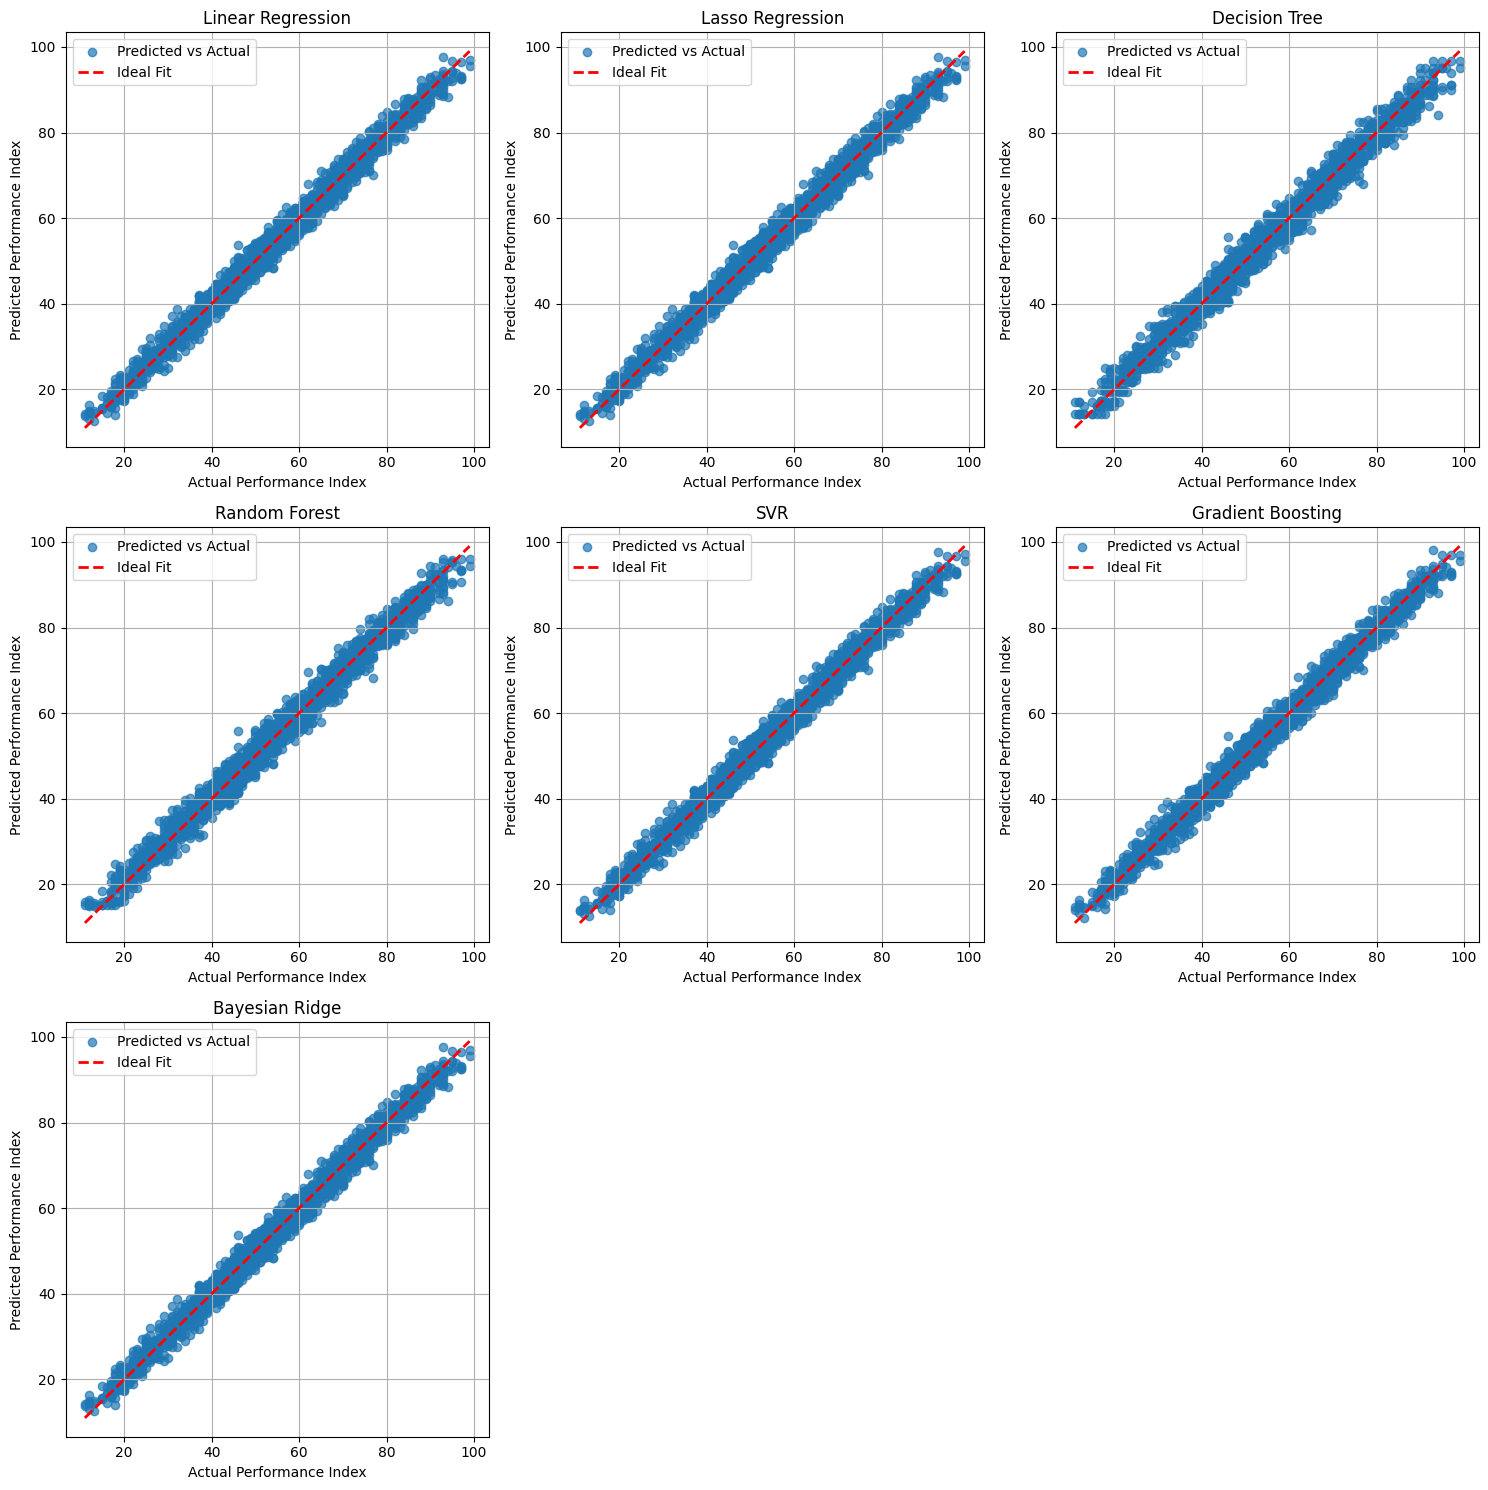

In [14]:
num_models = len(final_models)
cols = 3
rows = (num_models + cols - 1) // cols

plt.figure(figsize=(15, 5 * rows))
for i, (name, model) in enumerate(final_models.items(), 1):
    y_pred = model.predict(X_test)

    plt.subplot(rows, cols, i)
    plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
    plt.xlabel('Actual Performance Index')
    plt.ylabel('Predicted Performance Index')
    plt.title(f'{name}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Tuned vs Untuned Model

In [ ]:
fig = go.Figure()

for i, name in enumerate(tuned_models):
    tuned_model = tuned_models.get(name)
    base_model = models.get(name)

    y_pred_tuned = tuned_model.predict(X_test)
    mse_tuned = mean_squared_error(y_test, y_pred_tuned)

    if base_model:
        y_pred_base = base_model.predict(X_test)
        mse_base = mean_squared_error(y_test, y_pred_base)
    else:
        y_pred_base = y_pred_tuned
        mse_base = mse_tuned

    fig.add_trace(
        go.Scatter(
            x=y_test,
            y=y_pred_tuned,
            mode='markers',
            name=f'{name} - Tuned',
            marker=dict(color='orange', size=8, opacity=0.6),
        )
    )

    fig.add_trace(
        go.Scatter(
            x=y_test,
            y=y_pred_base,
            mode='markers',
            name=f'{name} - Base',
            marker=dict(color='lightblue', size=8, opacity=0.6),
        )
    )

    fig.add_trace(
        go.Scatter(
            x=[y_test.min(), y_test.max()],
            y=[y_test.min(), y_test.max()],
            mode='lines',
            name='Ideal Fit',
            line=dict(color='black', dash='dash'),
            showlegend=(i == 0)
        )
    )

    z_tuned = np.polyfit(y_test, y_pred_tuned, 1)
    p_tuned = np.poly1d(z_tuned)
    fig.add_trace(
        go.Scatter(
            x=y_test,
            y=p_tuned(y_test),
            mode='lines',
            name=f'{name} - Tuned Trendline',
            line=dict(color='brown', width=2),
        )
    )

    z_base = np.polyfit(y_test, y_pred_base, 1)
    p_base = np.poly1d(z_base)
    fig.add_trace(
        go.Scatter(
            x=y_test,
            y=p_base(y_test),
            mode='lines',
            name=f'{name} - Base Trendline',
            line=dict(color='blue', width=2),
        )
    )

    fig.add_annotation(
        xref="paper", yref="paper",
        x=1.02, y=1 - i * 0.12,
        text=f"<b>{name}</b><br>Tuned MSE: {mse_tuned:.2f}<br>Base MSE: {mse_base:.2f}",
        showarrow=False,
        font=dict(size=12),
        align="left",
        bordercolor="black",
        borderwidth=1,
        bgcolor="white",
        opacity=0.9
    )

fig.update_layout(
    height=800,
    width=1200,
    title_text="Predicted vs Actual Performance Index: Base vs Tuned Models",
    showlegend=True,
    legend=dict(x=1.05, y=1),
    template="plotly_white"
)

fig.update_xaxes(title_text="Actual Performance Index")
fig.update_yaxes(title_text="Predicted Performance Index")

fig.write_html("plots/predicted_vs_actual_comparison.html")
fig.show()

### 6.2 Residual Plots
We check residuals to assess model assumptions.

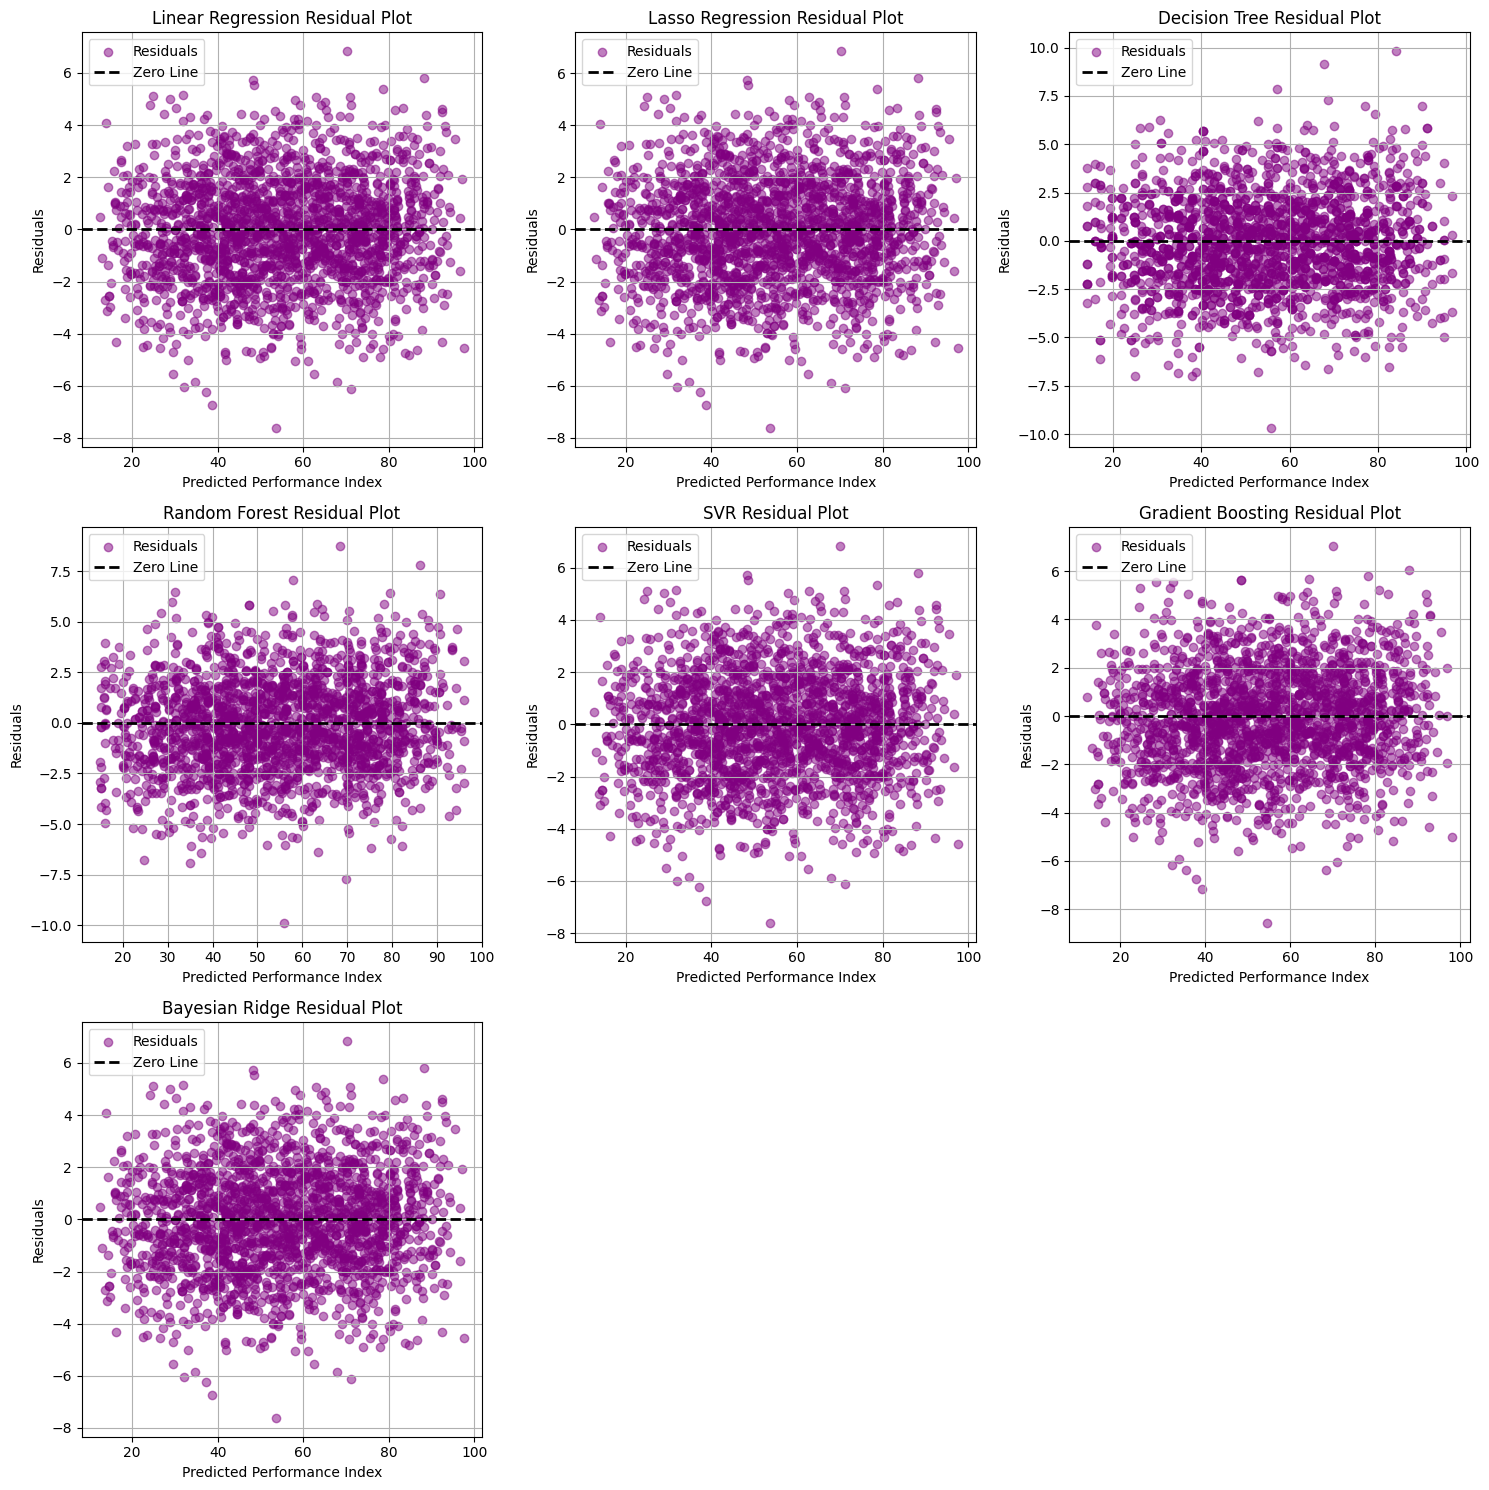

In [16]:
plt.figure(figsize=(15, 5 * rows))
for i, (name, model) in enumerate(final_models.items(), 1):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.subplot(rows, cols, i)
    plt.scatter(y_pred, residuals, alpha=0.5, color='purple', label='Residuals')
    plt.axhline(y=0, color='0', linestyle='--', lw=2, label='Zero Line')
    plt.xlabel('Predicted Performance Index')
    plt.ylabel('Residuals')
    plt.title(f'{name} Residual Plot')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Tuned vs Untuned Model

In [ ]:
fig = sp.make_subplots(rows=1, cols=1)

for i, name in enumerate(tuned_models):
    tuned_model = tuned_models.get(name)
    base_model = models.get(name)

    y_pred_tuned = tuned_model.predict(X_test)
    residuals_tuned = y_test - y_pred_tuned
    mse_tuned = mean_squared_error(y_test, y_pred_tuned)

    y_pred_base = base_model.predict(X_test)
    residuals_base = y_test - y_pred_base
    mse_base = mean_squared_error(y_test, y_pred_base)

    fig.add_trace(
        go.Scatter(
            x=y_pred_tuned,
            y=residuals,
            mode='markers',
            name=f"Tuned {name} Residuals",
            marker=dict(size=8, opacity=0.6, color="orange"),
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=y_pred_base,
            y=residuals,
            mode='markers',
            name=f"Base {name} Residuals",
            marker=dict(size=8, opacity=0.6, color="blue"),
        ),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
            x=[y_pred.min(), y_pred.max()],
            y=[0, 0],
            mode='lines',
            name='Zero Line',
            line=dict(color='black', dash='dash'),
            showlegend=(i == 0)
        ),
        row=1, col=1
    )

    fig.add_annotation(
        xref="paper", yref="paper",
        x=1.02, y=1 - i * 0.1,
        text=f"<b>{name}</b><br>Tuned MSE: {mse_tuned:.2f}<br>Base MSE: {mse_base:.2f}",
        showarrow=False,
        font=dict(size=12),
        align="left",
        bordercolor="black",
        borderwidth=1,
        bgcolor="white",
        opacity=0.9
    )

fig.update_layout(
    height=700,
    width=1200,
    title_text="Predicted vs Actual Residuals vs Predicted Values: Before and After Tuning SVR",
    showlegend=True,
    legend=dict(x=1.05, y=1),
    template="plotly_white"
)

fig.update_xaxes(title_text="Predicted Performance Index")
fig.update_yaxes(title_text="Residuals")

fig.write_html("plots/residuals_plot_interactive.html")
fig.show()

###6.3 Comparison of regression metrics

In [ ]:
metrics = ['Train MSE', 'Train MAE', 'Train R2', 'Test MSE', 'Test MAE', 'Test R2']
df_normalized = results_df.copy()
for metric in metrics:
    if 'MSE' in metric or 'MAE' in metric:
        # Інвертуємо нормалізацію: нижче значення -> ближче до 1
        df_normalized[metric] = (results_df[metric].max() - results_df[metric]) / (results_df[metric].max() - results_df[metric].min())
    else:
        # Для R2: вище значення -> ближче до 1
        df_normalized[metric] = (results_df[metric] - results_df[metric].min()) / (results_df[metric].max() - results_df[metric].min())

fig = go.Figure()

colors = ['#FF6F61', '#6B728E', '#FFD60A', '#06D6A0', '#EF476F', '#118AB2', '#073B4C', '#F4A261']

for i, model in enumerate(results_df['Model']):
    values = df_normalized.loc[i, metrics].values.tolist()
    labels = metrics.copy()

    values.append(values[0])
    labels.append(labels[0])

    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=labels,
        name=model,
        line=dict(color=colors[i % len(colors)]),
        opacity=0.7,
        hovertemplate='<b>%{fullData.name}</b><br>Metric: %{theta}<br>Normalized Value: %{r:.2f}<extra></extra>'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True,
    title="Radar Chart: Model Performance Metrics Comparison",
    width=800,
    height=600,
    template="plotly_white",
    legend=dict(x=1.1, y=1.0)
)

fig.write_html("plots/radar_chart_metrics.html")
fig.show()

In [ ]:
predictions = {'Actual': y_test}
for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions[name] = y_pred

df_predictions = pd.DataFrame(predictions)

# Створюємо графік
fig = go.Figure()

colors = {
    'Actual': '#000000',
    'Linear Regression': '#FF6F61',
    'Lasso Regression': '#6B728E',
    'Decision Tree': '#FFD60A',
    'Random Forest': '#06D6A0',
    'SVR': '#EF476F',
    'Gradient Boosting': '#118AB2',
    'Bayesian Ridge': '#073B4C',
    'Tuned SVR': '#F4A261'
}

for col in df_predictions.columns:
    data = df_predictions[col].dropna()
    kde = stats.gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    y_vals = kde(x_vals)

    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='lines',
        name=col,
        line=dict(color=colors[col]),
        opacity=0.3 if col != 'Actual' else 1.0,
        hovertemplate=f'<b>{col}</b><br>Performance Index: %{{x:.2f}}<br>Density: %{{y:.2f}}<extra></extra>'
    ))

fig.update_layout(
    title="Density Plot of Actual vs Predicted Performance Index Values",
    xaxis_title="Performance Index (Target Value)",
    yaxis_title="Density",
    width=1200,
    height=700,
    template="plotly_white",
    legend=dict(x=1.05, y=1.0),
    showlegend=True
)

fig.write_html("plots/predicted_values_density.html")
fig.show()

Linear Regression, Lasso Regression, Bayesian Ridge, and Tuned SVR best reproduce the distribution of actual values, making them ideal for accurate forecasting.

In [ ]:
residuals = {}
for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    resid = y_test - y_pred
    residuals[name] = resid

df_residuals = pd.DataFrame(residuals)

fig = px.box(df_residuals, title="Box Plot of the distribution of residuals for all models",
             labels={"value": "Density", "variable": "Model"})
fig.update_layout(
    width=1000,
    height=600,
    template="plotly_white",
    yaxis_title="Residuals",
    xaxis_title="Model",
    showlegend=False
)
fig.write_html("plots/box_plot.html")
fig.show()

## 7. Conclusion
Based on the data analysis and regression model results, we can draw the following conclusions.
  
**Feature Importance:** "Previous Scores" and "Hours Studied" are key factors in student performance, with high importance coefficients in all models. Other features such as "Sleep Hours", "Sample Question Papers Practiced" and "Extracurricular Activities" have minimal impact. However, the dropping of functions led to a worsening of the result.

**Models Performance:**
* Decision Tree, Random Forest suffer from overfitting, making them less suitable without additional tuning.
* Linear Regression, Lasso Regression, Bayesian Ridge and SVR are the most stable models with the smallest residual variance, making them the best for accurate and reliable forecasting. Gradient Boosting also shows normal results.

**Tuning Efficiency:**  
Tuned SVR significantly improved performance compared to the baseline (Test MSE: 4.0822 vs. 5.4209), highlighting the importance of hyperparameter tuning.